In [232]:
# given some description of the encoding rule, expand a logical circuit into an encoded circuit
# this entails interleaving the logical circuit with syndrome measurement and error correction
# each logical operator should be expanded into the encoded manifold as well
# NOTE: we could think about how to generalize this to codes, but for now its okay to keep specific to ours
from qiskit.quantum_info import random_clifford
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from quantum_logical.basis import RepetitionEncoding
from qiskit.quantum_info import Operator
from quantum_logical.encoded_layout import EncodedEquivalenceLibrary
from qiskit.circuit.library import ZGate, XGate, CZGate
from quantum_logical.deprecated.unitary_util import ImplicitUnitaryGate
from quantum_logical.encoded_layout import EncodedCircuitExpansionPass
from qiskit.transpiler import PassManager
import numpy as np

In [233]:
encoding1 = RepetitionEncoding(phase_flip=True)

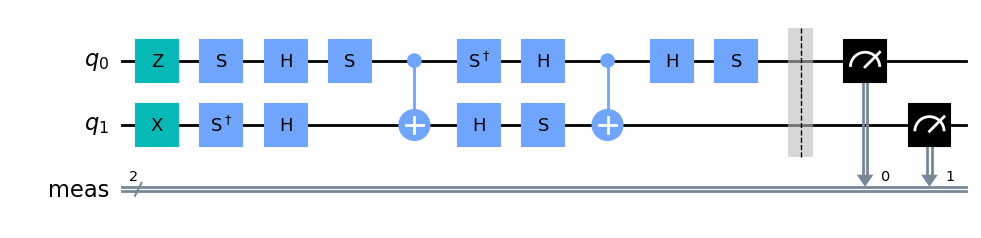

In [234]:
# Initialize a random Clifford circuit and transpile it with specific basis gates and optimization levels for encoding and transformation.

input_circuit = random_clifford(2, seed=1).to_circuit()
input_circuit = transpile(
    input_circuit,
    basis_gates=["sdg", "s", "h", "hdg", "x", "xdg", "z", "zdg", "cx", "id"],
    optimization_level=3,
)
input_circuit.measure_all()
input_circuit.draw(output="mpl")

To create logical operators use the following transformation:
\begin{align*}
A = |L_0\rangle\langle0| + |L_1\rangle\langle1|\\
U' = A U A^\dagger
\end{align*}
where U is the logical unitary that acts on the $|0\rangle$ and $|1\rangle$ states.


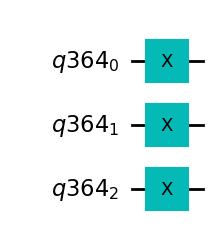

In [235]:
# ## Logical Operator Transformation
# Describing the transformation rule for logical operators and applying it to the quantum circuit.

qr = QuantumRegister(3)
logical_circuit = QuantumCircuit(qr)
# logical_circuit.h(0)
logical_circuit.x(0)
logical_circuit.x(1)
logical_circuit.x(2)
# logical_circuit.z(qr)

logical_circuit.draw("mpl")

In [236]:
# Converting encoded operators into logical operators

encoding_transform = encoding1.transform_operator.full()
logical_op = (
    encoding_transform.conj().T @ Operator(logical_circuit).data @ encoding_transform
)
logical_op.round()

array([[ 1.+0.j, -0.+0.j],
       [ 0.+0.j, -1.+0.j]])

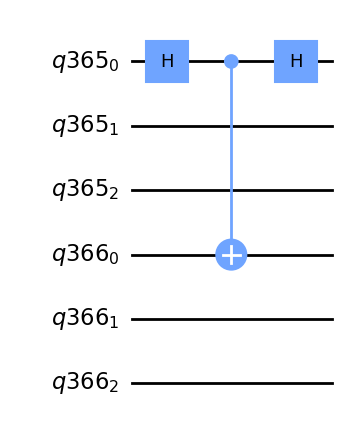

In [237]:
qr1, qr2 = QuantumRegister(3), QuantumRegister(3)
logical_circuit2 = QuantumCircuit(qr1, qr2)
# logical_circuit3.cx(qr1[0], qr2[0])
# logical_circuit3.cx(qr1[1], qr2[1])
# logical_circuit3.cx(qr1[2], qr2[2])
logical_circuit2.h(qr1[0])
logical_circuit2.cx(qr1[0], qr2[0])
logical_circuit2.h(qr1[0])
# logical_circuit2.cz(qr1[0], qr2[0])
logical_circuit2.draw("mpl")

In [238]:
# Converting encoded operators into logical operators

encoding_transform = encoding1.transform_operator.full()
transform_op = np.kron(encoding_transform, encoding_transform)
logical_op = transform_op.conj().T @ Operator(logical_circuit2).data @ transform_op
logical_op.round()

array([[ 1.+0.j, -0.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j, -0.+0.j],
       [-0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j]])

In [239]:
# Converting logical operators into encoded operators
encoding2 = RepetitionEncoding(phase_flip=False)
encoding_transform = encoding2.transform_operator.full()
inefficient_new_op = (
    encoding_transform @ XGate().to_matrix() @ encoding_transform.conj().T
)
inefficient_new_op

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

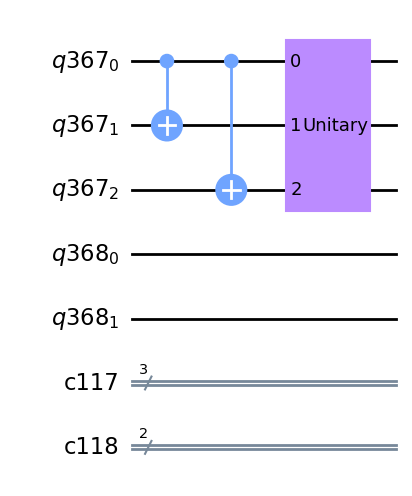

In [240]:
# ## Inefficient Decomposition Example
# Demonstrating an example of inefficient decomposition in quantum circuits.

qr = QuantumRegister(3)
ar = QuantumRegister(2)
cqr = ClassicalRegister(3)
car = ClassicalRegister(2)
inefficient_circuit = QuantumCircuit(qr, ar, cqr, car)
inefficient_circuit = encoding2.encoding_circuit(inefficient_circuit, qr)
inefficient_circuit.append(ImplicitUnitaryGate(inefficient_new_op), qr)
inefficient_circuit.draw("mpl")

In [241]:
# ## Comparison of Operator Indices
# Analyzing the 'don't care' indices in the operator representations to understand the challenges in multi-qubit decomposition.

# Discussing the differences between the 'don't care' indices in inefficient_new_op and logical_op. Highlighting how off-diagonal indices in inefficient_new_op contrast with the diagonal assumption in logical_op, posing transpilation challenges.

print(ImplicitUnitaryGate(inefficient_new_op).to_matrix())
print("\n")
print(Operator(logical_circuit).data)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [242]:
# transpile(
#     inefficient_circuit,
#     basis_gates=["u", "cx"],
# ).draw("mpl")

In [243]:
# Defining an encoded equivalence library to find reasonable physical circuits that equate to useful logical circuits, such as logical X, Z, CNOT gates.
encoding1_lib = EncodedEquivalenceLibrary(code_length=3)

# decomp rules specific to phase_flip = True

logical_z = QuantumCircuit(3)
logical_z.x(0)
logical_z.x(1)
logical_z.x(2)

logical_x = QuantumCircuit(3)
logical_x.z(0)
logical_x.z(1)
logical_x.z(2)

logical_cz = QuantumCircuit(6)
logical_cz.h(0)
logical_cz.cx(0, 3)
logical_cz.h(0)

logical_delay = QuantumCircuit(3)

encoding1_lib.add_equivalence(ZGate(), logical_z)
encoding1_lib.add_equivalence(XGate(), logical_x)
encoding1_lib.add_equivalence(CZGate(), logical_cz)
logical_basis_gates = [k.name for k in encoding1_lib.keys()]

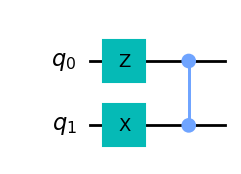

In [244]:
simple_input = QuantumCircuit(2)
simple_input.z(0)
simple_input.x(1)
simple_input.cz(0, 1)

# first, prepare input for the encoded circuit expansion pass
simple_input = transpile(
    simple_input,
    basis_gates=logical_basis_gates,
    optimization_level=3,
)
# simple_input.measure_all()
simple_input.draw("mpl")

In [245]:
# # TODO
# simple_input = QuantumCircuit(1)
# simple_input.x(0)
# simple_input.delay(100, 0)

# # first, prepare input for the encoded circuit expansion pass
# simple_input = transpile(
#     simple_input,
#     basis_gates=logical_basis_gates,
#     optimization_level=3,
# )

# simple_input.draw("mpl")

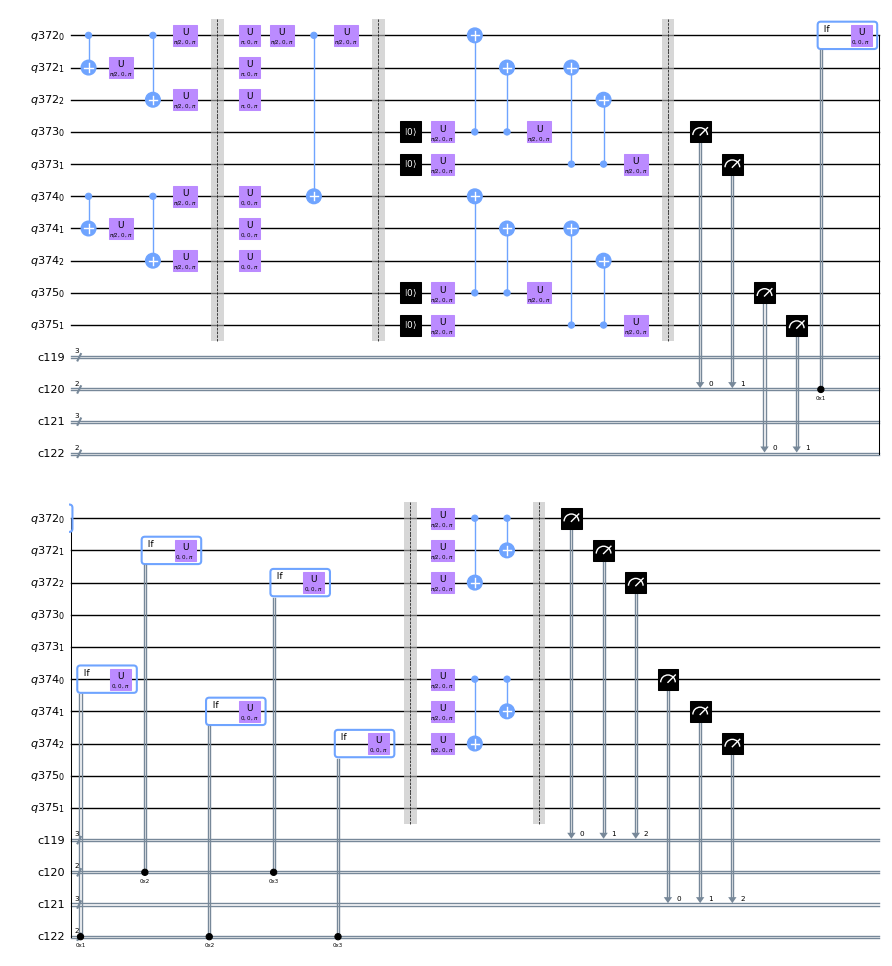

In [246]:
translator = EncodedCircuitExpansionPass(
    encoding1, encoding1_lib, target_basis=["x", "z", "cx"]
)
simple_output_prep = translator(simple_input)

# second, optimize within the encoded basis
physical_basis_gates = ["u", "cx", "if_else"]
simple_output = transpile(
    simple_output_prep,
    basis_gates=physical_basis_gates,
    optimization_level=0,
)

simple_output.draw("mpl", scale=0.5)

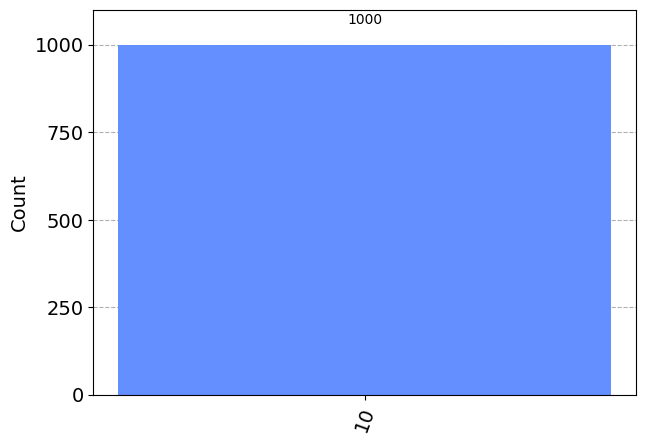

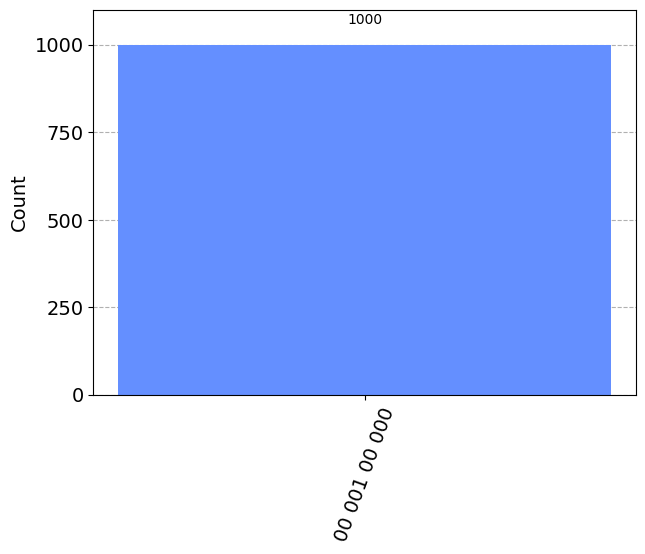

In [247]:
from qiskit import Aer
from qiskit.visualization import plot_histogram

# We first choose a simulator as our backend without any noise
backend = Aer.get_backend("qasm_simulator")

simple_input.measure_all()
counts = backend.run(simple_input, shots=1000).result().get_counts()
display(plot_histogram(counts))

# We run the simulation and get the counts
counts = backend.run(simple_output, shots=1000).result().get_counts()
# And now we plot a histogram to see the possible outcomes and corresponding probabilities
display(plot_histogram(counts))